## Imber Tutorial 1: Estimating ELT Doppler Imaging Performance

by [Michael K. Plummer](www.michaelplummer.dev)

Welcome to this tutorial on using the [Imber](https:github.com/mkplummer/Imber) Python code to estimate the Doppler imaging performance of ELT Instruments. The numerical and analytical models for [Imber](https:github.com/mkplummer/Imber) were created and described in [Plummer & Wang, 2022](https://ui.adsabs.harvard.edu/abs/2022ApJ...933..163P/abstract). In this tutorial we will:
- Setup a target (star, brown dwarf, or planet)
- Add a spot to that target
- Numerically generate a surface map, spectral line profiles, and light curve
- Qualitatively compare those line profiles and light curves to our analytical model
- Perform Bayesian inference via Dynesty to fit a numerically-generated simulated observation with our analytical model

First, we will import our code, target list, and instrument list (which need to be in the same file as this Jupyter notebook):

In [5]:
import Imber
import target_list
import instrument_list

Next, we import our dependencie. Note that there are further dependencies within the Imber.py file which include **AstroPy, Dynesty, Matplotlib, Numpy, Pandas, SciPy, SecretColors, SpecUtils, TQDM**. These should be installed prior to using Imber.

In [2]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from SecretColors import Palette

The *IBM* color palette is selected for visual inclusivity.

In [3]:
p = Palette("ibm") # 'ibm' 'brewer' 'material' 'clarity

We import our desired target and instrument from our lists which should also be stored in the same file as this notebook.

In [6]:
'Import target & instrument'
target1 = target_list.VHS1256b_METIS
instrument = instrument_list.METIS


We can now add spots to the target's surface.

In [7]:
'Set Spots (Truth)'
lat,lon,radius,contrast = [30],[30],[30],[0.25]
target1.set_spots(lat,lon,radius,contrast)


We create a numerical model using a grid of the target's surface. Here is the list of required parameters, units, and a brief description:
- length_of_observation (hrs): Total period over which observations are conducted. If greater than rotational period, then multiple rotations are modeld.
- time_steps (#): Number of time samples
- n (#): Number of elements for the spectral line profile
- eps: Linear limb darkening coefficient
- spectral_resolution (R): Determined by selected instrument



In [32]:
'Model Settings'
length_of_observation = target1.period
time_steps = 30
n =  51
eps = 0.4
spectral_resolution = instrument.spectral_resolution

'Numerical Model'
model_numerical = Imber.Numerical_Model(target1,length_of_observation,time_steps,n,eps,spectral_resolution)
model_numerical.run()


/Users/plummer.323/Imber/Imber.py:1244: RuntimeWarning: invalid value encountered in sqrt
  mu = np.sqrt(1-(latcell**2+loncell**2)/90**2)


We can produce a map of the target's surface with the numerical model.

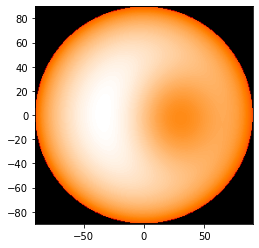

In [10]:
model_numerical.create_map(0) # Here 0 denotes the time stamp you would like to reference for the map.

Next, we use the target's numerical model, as well as the instrument, to create a simulated observation. Here are the required inputs:
- texp (s): Exposure time, here we divide up the length of observations by the time samples and subtract 60 s to allow time for photometry.
- nexp (3): Number of Exposures
- host_star: Either True or False. If True, starlight suppression levels need to be included in the instrument list.
- Lambda: Least Squares Deconvolution Regularization Parameter (higher >> smoother)

In [33]:
'Spectroscopic Observation (Simulated)'
texp = int(length_of_observation*3600/time_steps)-60
nexp = 1 
obs1 = Imber.Simulated_Observation(instrument,model_numerical,texp,nexp,host_star = False)
Lambda = 10 
obs1.create_line_profile(Lambda)

100%|██████████| 30/30 [00:24<00:00,  1.21it/s]


For demonstration, we will also create an analytical model with the same spot parameters. We also generate corresponding analytical line profiles and light curves. The analytical model requires the same inputs as the numerical model.

In [34]:
'Analytical Model'
model_analytical = Imber.Analytical_Model(target1, length_of_observation, time_steps, n, eps, spectral_resolution)
model_analytical.create_line_profile()
model_analytical.rotational_plus_instrument_kernel()
model_analytical.create_lightcurve()

To demonstrate the analytical model's fit of both the numerical model and simulated observation, we plot the line profile for the first time step.

Text(0, 0.5, 'Intensity')

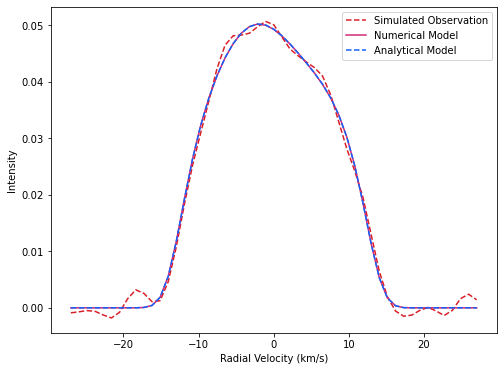

In [38]:
'Line Profile Plot'
fig,ax = plt.subplots(figsize=(8,6))
shade = 60
plt.plot(model_numerical.rv_array,obs1.line_profile[0],color = p.red(shade = shade),ls = '--',label='Simulated Observation')
plt.plot(model_numerical.rv_array,model_numerical.line_profile[0],color = p.magenta(shade = shade),label = 'Numerical Model')
plt.plot(model_analytical.rv_array,model_analytical.line_profile[0],color = p.blue(shade = shade),ls = '--',label ='Analytical Model')
plt.legend()
plt.xlabel('Radial Velocity (km/s)')
plt.ylabel('Intensity')

Next, we create a photometric observation to produce simulated observed light curves. We use the METIS Imager from instrument_list for our simualted observation.

In [36]:
'Photometric Observation (Simulated)'
texp = 60
nexp = 1
instrument_photo = instrument_list.METISimager
obs2 = Imber.Simulated_Observation(instrument_photo,model_numerical,texp,nexp,host_star = False)
obs2.create_lightcurve()

/Users/plummer.323/Imber/Imber.py:1244: RuntimeWarning: invalid value encountered in sqrt
  mu = np.sqrt(1-(latcell**2+loncell**2)/90**2)


Now we demonstrate our analytical model's fit to the simulated light curve.

Text(0, 0.5, 'Relative Flux')

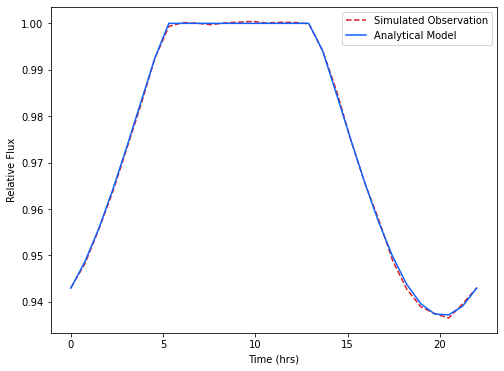

In [39]:
'Light Curve Plot'
fig,ax = plt.subplots(figsize=(8,6))
shade = 60
time = np.linspace(0,length_of_observation,time_steps)
plt.plot(time,obs2.model.light_curve,color = p.red(shade = shade),ls = '--',label='Simulated Observation')
plt.plot(time,model_analytical.light_curve,color = p.blue(shade = shade),label ='Analytical Model')
plt.legend()
plt.xlabel('Time (hrs)')
plt.ylabel('Relative Flux')

Now we will infer spot latitude, longitude, and radius in the simualted spectroscopic and photometric observations using our analytical model. Here are the required parameters:

- truths: truth parameters for selecting # of free parameters within Dynesty nested sampling
- time_samples: # of samples used by analytical fit which are then interpolated from when fitting data. Essentially higher values lead to more accurate retrievals, but with longer run times.
- spectral_obervation: spectral observation object created above, if you do not want to use spectral data, set to 0 (defaults to 0)
- photo_observation: photometric observation object created above, if you do not want to use photometric data, set to 0 (defaults to 0)
- free_radius: True or False, select whether or not you want radius to be free parameter (defaults to False)
- free_contrast: True or False, select whether or not you want contrast to be free parameter (defaults to False)

Nested sampling and the following three plots are conducted/created using [Dynesty](https://dynesty.readthedocs.io/en/stable/).


18820it [08:33, 36.65it/s, batch: 6 | bound: 19 | nc: 23 | ncall: 399027 | eff(%):  4.716 | loglstar: 266.255 < 271.153 < 270.320 | logz: 253.538 +/-  0.116 | stop:  0.985]               


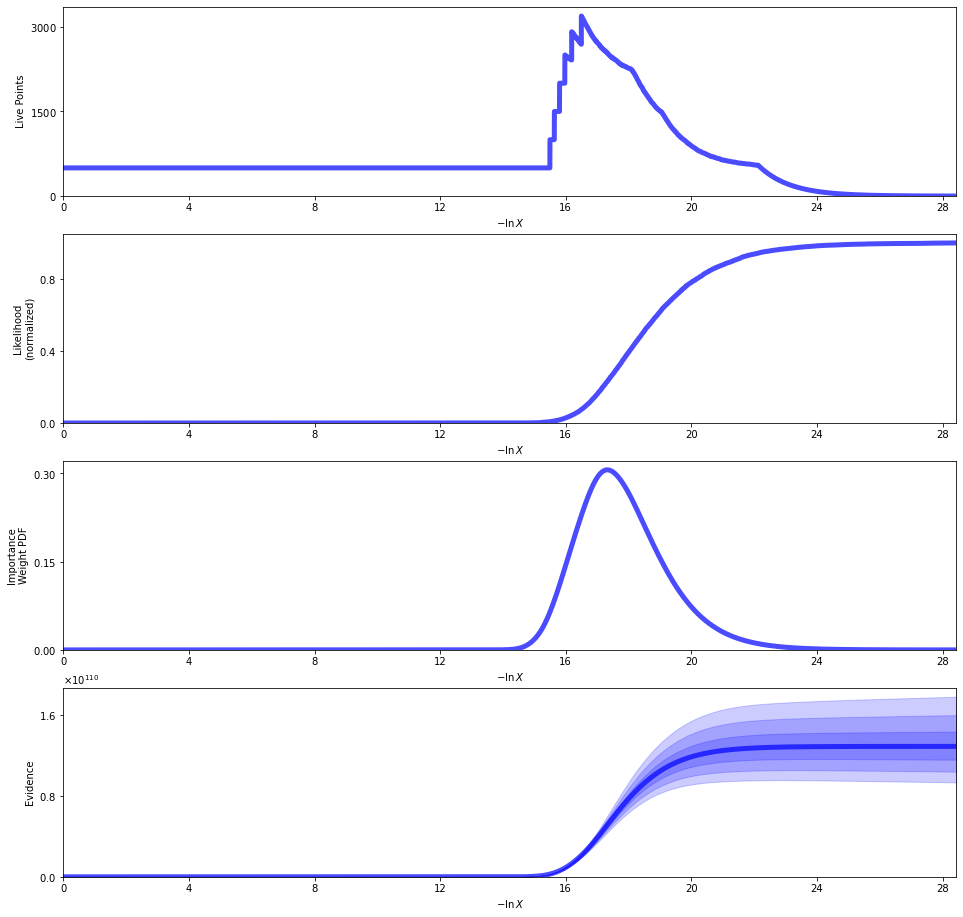

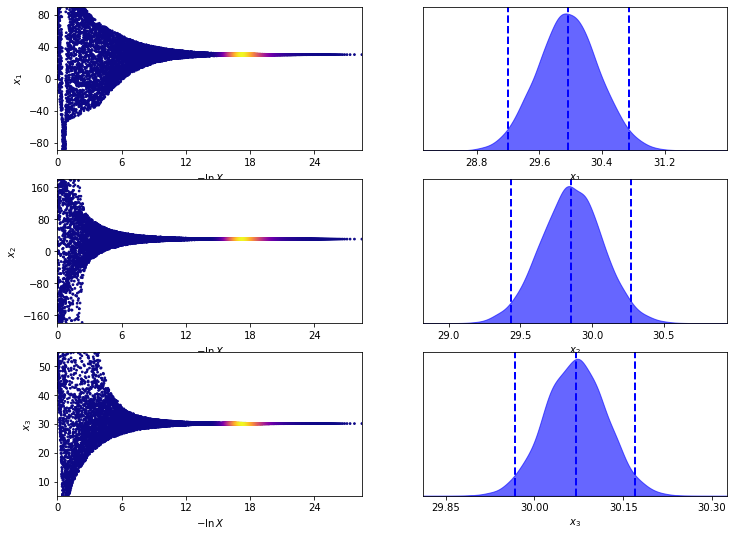

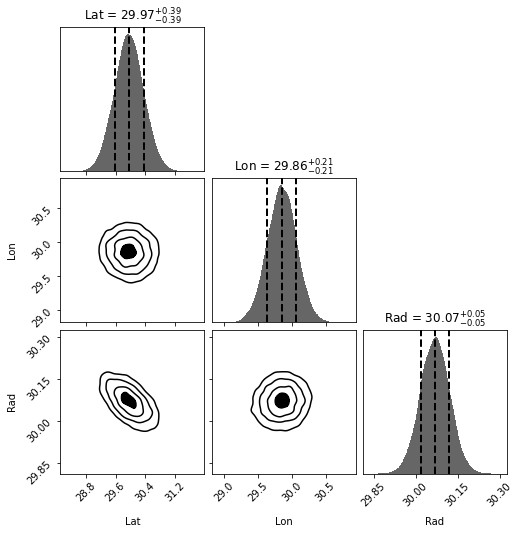

In [40]:
truths = [lat,lon,radius,contrast]
time_samples = 500
inference = Imber.NestedSampling(target1, time_samples,spectral_observation = obs1,photo_observation = obs2,\
                                 free_radius = True,truths = truths)
inference.run()

We can use the inferred maximum likelihood posterior values to re-run the analytical model and check our inferred solution.

In [41]:
'Input Inferred Values'
lat,lon,radius,contrast = [29.97],[29.86],[30.07],[0.25]
target1.set_spots(lat,lon,radius,contrast)
'Recompute Analytical Model'
model_analytical = Imber.Analytical_Model(target1, length_of_observation, time_steps, n, eps, spectral_resolution)
model_analytical.create_line_profile()
model_analytical.rotational_plus_instrument_kernel()
model_analytical.rotational_broadening_kernel()

In the next figure, we plot the deviations of the simulated observations and inferred model from the mean line profile. We also include the residuals to visually check the quality of our analytical fit.

Text(0.5, 1.0, 'Residuals')

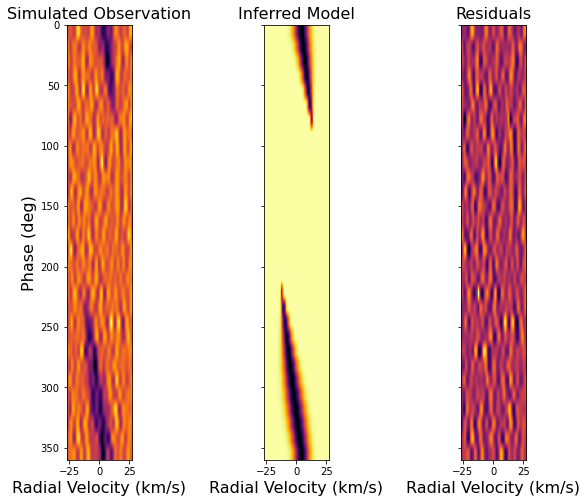

In [42]:
'Deviation Plot Calculations'
LPanalytical = model_analytical.line_profile
Zstd = model_analytical.LPrb_plus_instrument
obs_dev = np.zeros((time_steps,n)) #Empty 2D Array
for i in range(time_steps): #Filling the 2D Array
    obs_dev[i] = (obs1.line_profile[i,:]-Zstd)
model_dev = np.zeros((time_steps,n)) #Empty 2D Array
for i in range(time_steps): #Fill the 2D Array
    model_dev[i] = (LPanalytical[i,:]-Zstd) 
residual = obs_dev-model_dev

'Deviation Plots'
color = 'inferno'
extent = [model_analytical.rv_array[0],model_analytical.rv_array[n-1],360,0,]
fig, axarr = plt.subplots(nrows=1, ncols=3, figsize=(10,8),sharex=True,sharey=True)
plt.subplots_adjust(wspace=0.2, hspace=0.2)
axarr[0].imshow(obs_dev,cmap = color,extent = extent)
axarr[0].set_title('Simulated Observation',fontsize = 16)
axarr[0].set_ylabel('Phase (deg)',fontsize = 16)
axarr[0].set_xlabel('Radial Velocity (km/s)',fontsize = 16)
axarr[1].imshow(model_dev,cmap = color,extent = extent)
axarr[1].set_xlabel('Radial Velocity (km/s)',fontsize = 16)
axarr[1].set_title('Inferred Model',fontsize = 16)
axarr[2].imshow(residual,cmap = color,extent = extent)
axarr[2].set_xlabel('Radial Velocity (km/s)',fontsize = 16)
axarr[2].set_title('Residuals',fontsize = 16)